# MLE 2023 Workshop Notebook

This notebook contains a template for the joint exercise regarding physics informed deep learning and TorchPhysics.

We start by solving the Laplace equation:

\begin{align*}
    \Delta u &= 1 &&\text{ in } \Omega \\
    u &= 0 , &&\text{ on } \partial \Omega
\end{align*}

with $\Omega = [0, 1] \times [0, 1]$.

First we have to install the library:

In [1]:
!pip install torchaudio==0.13.0
!pip install torchphysics

import torch

Next we implement the *Spaces* that appear in the problem:

In [2]:
import torchphysics as tp
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Now we define our domain, the unit square:

In [3]:
omega = tp.domains.Parallelogram(X, [0,0], [1,0], [0,1])

For the training we need to create some points, this is handle by the *Sampler*:

In [4]:
inner_sampler = tp.samplers.RandomUniformSampler(omega, n_points=15000)

bound_sampler = tp.samplers.GridSampler(omega.boundary, n_points=5000)

We need a neural network that should learn our solution:

In [5]:
model = tp.models.FCN(input_space=X, output_space=U, hidden=(20,20,20))

Now, we have to transform out mathematical conditions given by our PDE into corresponding training conditions. First for the differential equation itself:

In [6]:
def pde_residual(u, x):
    return tp.utils.laplacian(u, x) - 1.0

pde_cond = tp.conditions.PINNCondition(model, inner_sampler, pde_residual)

Next for the boundary condition:

In [11]:
def boundary_residual(u, x):
    return u - 0.0

boundary_cond = tp.conditions.PINNCondition(model, bound_sampler, boundary_residual, weight=50.0)

Before the training we collect all conditions and choose our training procedure:

In [12]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([boundary_cond, pde_cond], optimizer_setting=optim)

Start the training:

In [13]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, # use one GPU
                     max_steps=3000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False) # saving checkpoints
trainer.fit(solver)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 921   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
921       Trainable 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3000` reached.


Lastly, we can plot the solution:

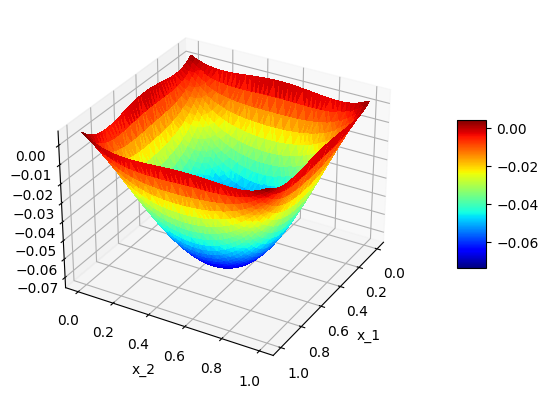

In [14]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=omega,
                                       n_points=2000)
fig = tp.utils.plot(model, lambda u : u, plot_sampler)